# Physics-Informed Neural Network for the Kuramoto-Sivashinsky Equation

This notebook implements a PINN for solving the Kuramoto-Sivashinsky equation using DeepXDE.

In [1]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Data Loading

First, we define a function to load and process the training data.

In [2]:
def load_training_data(params):
    """Load and process training data"""
    training_data = np.load('../../../data/ks_training.npy')
    t = np.linspace(0, params['T']/2, training_data.shape[0])  # First half of time domain
    x = np.linspace(0, params['L'], params['N'])
    
    # Create observation points
    X, T = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    y_train = training_data.flatten()[:, None]
    
    return X_train, y_train

## PINN Model Definition

Next, we define the PINN model including:
- PDE definition
- Geometry setup
- Initial and boundary conditions
- Neural network architecture

In [3]:
def ks_pinn(params=None, load_pretrained=False, model_path=None):
    if params is None:
        params = {
            'L': 30,
            'N': 2048,
            'dt': 0.5,
            'T': 100,
        }
    
    L, N = params['L'], params['N']
    dt, T = params['dt'], params['T']
    
    def pde(x, y):
        dy_x = dde.grad.jacobian(y, x, i=0, j=0)
        dy_t = dde.grad.jacobian(y, x, i=0, j=1)
        dy_xx = dde.grad.hessian(y, x, i=0, j=0)
        return dy_t + y * dy_x - 0.01 / np.pi * model.net.nu * dy_xx

    space_domain = dde.geometry.Interval(0, L)  
    time_domain = dde.geometry.TimeDomain(0, T)
    geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

    def ic_func(x):
        return np.cos(x[:, 0:1]) + 0.1 * np.sin(2 * x[:, 0:1])

    ic = dde.IC(geomtime, ic_func, lambda _, on_initial: on_initial)
    
    bc = dde.icbc.PeriodicBC(geomtime, 0, lambda x, _: np.isclose(x[0], 0) or np.isclose(x[0], L))

    # Load training data
    X_train, y_train = load_training_data(params)
    
    # Create the PDE problem with both physics and data
    observe_x = dde.PointSetBC(X_train, y_train, component=0)
    
    data = dde.data.TimePDE(
        geomtime, 
        pde, 
        [bc, ic, observe_x],  # Include observation points
        num_domain=2540,
        num_boundary=80,
        num_initial=160,
    )

    net = dde.nn.FNN([2] + [40] * 4 + [1], "tanh", "Glorot normal")  # Deeper network
    model = dde.Model(data, net)

    # Create learnable parameter nu and register it with the model
    model.net.nu = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
    model.net._parameters['nu'] = model.net.nu

    # Compile with weighted losses
    model.compile("adam", lr=1e-2, loss_weights=[1, 1, 1, 10])  # weights: [PDE residual, IC, BC, data]

    # Load pretrained model if requested
    if load_pretrained and model_path:
        try:
            model.restore(model_path)
            print(f"Successfully loaded pretrained model from {model_path}")
            print(f"Loaded nu value: {model.net.nu.item()}")
        except Exception as e:
            print(f"Error loading pretrained model: {e}")
            print("Training from scratch instead.")
    
    # Create model directory for checkpoints
    os.makedirs("model", exist_ok=True)
    
    # Add callbacks
    checker = dde.callbacks.ModelCheckpoint(
        "saved_models/model.ckpt", 
        save_better_only=False, 
        period=1000
    )
    
    return model, checker

## Visualization Function

Define a function to visualize the solution.

In [4]:
def plot_solution(x, t, u):
    plt.figure(figsize=(10, 6))
    X, T = np.meshgrid(x, t)
    plt.pcolormesh(X, T, u, shading='auto')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Kuramoto-Sivashinsky Solution')
    plt.show()

## Training and Prediction

Now we'll train the model and generate predictions. You can choose to load a pretrained model or train from scratch.

In [5]:
# Set up parameters matching the data generator
params = {
    'L': 30,
    'N': 2048,
    'dt': 0.5,
    'T': 100,
    'num_steps': 201,  # Total steps for 0 to 100
}

# Specify whether to load a pretrained model
load_pretrained = True  # Set to True to load a pretrained model
model_path = "saved_models/model.ckpt-2000.pt"  # Path to the pretrained model

# Create and train model
model, checker = ks_pinn(params, load_pretrained=load_pretrained, model_path=model_path)

if not(load_pretrained):
    # Train the model
    losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[checker])

# Print learned parameter
print(f"Final nu value: {model.net.nu.item()}")

Compiling model...
'compile' took 0.604519 s

Successfully loaded pretrained model from saved_models/model.ckpt-2000.pt
Loaded nu value: 23.99333381652832
Final nu value: 23.99333381652832


## Visualize Training History

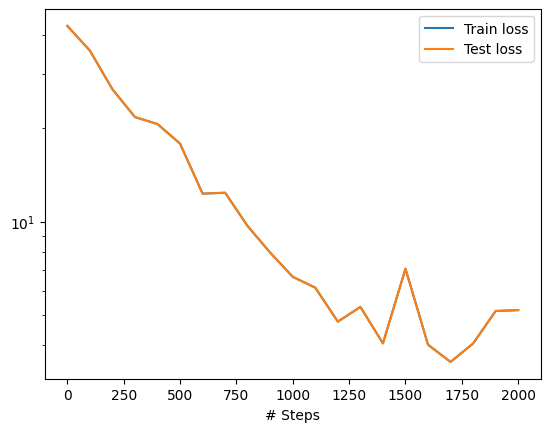

In [12]:
if not(load_pretrained):
    dde.utils.plot_loss_history(losshistory)

## Generate and Plot Predictions

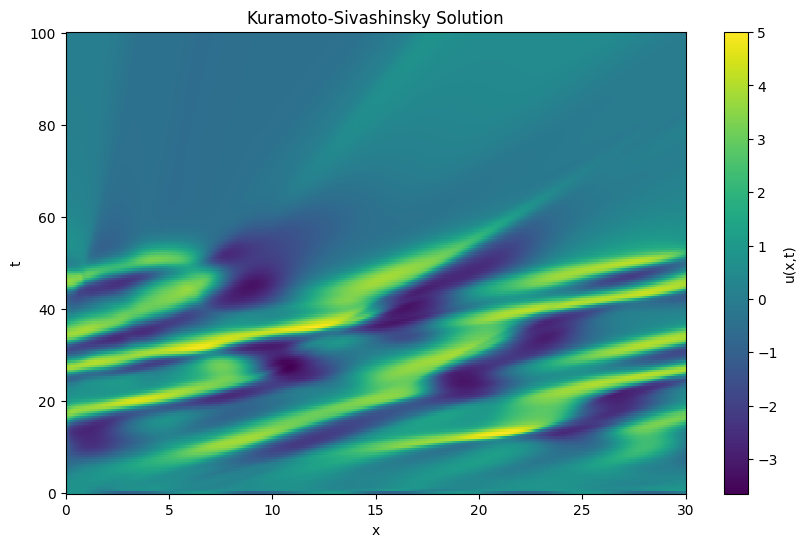

In [6]:
# Generate prediction points
t = np.linspace(0, params['T'], 201)
x = np.linspace(0, params['L'], params['N'])
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_pred = model.predict(X_star)
u_pred = u_pred.reshape(len(t), len(x))

plot_solution(x, t, u_pred)

## Save Predictions

In [7]:
# Save the prediction
TEAM_FOLDER = "../"
os.makedirs(TEAM_FOLDER, exist_ok=True)

PREDICTION_FILE = os.path.join(TEAM_FOLDER, "ks_prediction.npy")
np.save(PREDICTION_FILE, u_pred[int((params['num_steps']-1)/2)+1:params['num_steps']])

print(f"Saved prediction to: {PREDICTION_FILE}")
print(f"Prediction shape: {u_pred[int((params['num_steps']-1)/2)+1:params['num_steps']].shape}")

Saved prediction to: ../ks_prediction.npy
Prediction shape: (100, 2048)
